# 1 Getting and formatting the data

In [1]:
import sys
sys.path.append('/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/muon_info')
from simple_ctags import get_ctags
import pandas as pd

In [3]:
#Get the muons data
data = get_ctags("2018-04-22 00:00:00", "2018-04-25 00:00:00",'localhost')
df_muons = pd.DataFrame.from_dict(data, orient="index",columns=['ctags'])
df_muons.index.name = 'DateTime'
df_muons.index = pd.to_datetime(df_muons.index)
df_muons = df_muons.sort_values(by=['DateTime'])
df_muons.head()

,ctags
DateTime,
2018-04-22 00:00:26,0
2018-04-22 00:01:26,0
2018-04-22 00:02:26,0
2018-04-22 00:03:26,0
2018-04-22 00:04:26,0


In [4]:
#Get the field data
path = "../field_info/"
file = "60Hr_Average_Comparison_all_3956_3997_norescut.txt"
file = path + file
df_field = pd.read_csv(file, sep=" ", header=None)
df_field.columns = ["EpochTime", "D", "eD",
                    "NQ", "eNQ","SQ", "eSQ",
                    "NS", "eNS"]
df_field['DateTime'] = pd.to_datetime(df_field['EpochTime'],unit='s')
df_field = df_field.set_index('DateTime')
del df_field['EpochTime']
df_field.head()

,D,eD,NQ,eNQ,SQ,eSQ,NS,eNS
DateTime,,,,,,,,
2018-04-22 07:49:38,841.787,0.046244,0.127854,0.087027,-5.708530e+55,0.028346,-1.16032,0.028019
2018-04-22 07:49:48,841.814,0.046244,0.130324,0.087027,-5.724380e+55,0.028346,-1.16032,0.028019
2018-04-22 07:49:58,841.846,0.046244,0.135336,0.087027,-5.740240e+55,0.028346,-1.16032,0.028019
2018-04-22 07:50:08,841.864,0.046244,0.139565,0.087027,-5.756100e+55,0.028346,-1.16033,0.028019
2018-04-22 07:50:18,841.869,0.046244,0.127626,0.087027,-5.771950e+55,0.028346,-1.16033,0.028019


In [5]:
#Get the tracker data
import numpy as np
path = "../tracker_info/"
file = "beamSpot.txt"
file = path + file
names=['radial', 'vertical', 'counts']
df_tracker = pd.read_csv(file, sep=" ",names=names)
df_tracker.index.name = 'index'

#Make a 'Station' column to keep a record of where the readings came from
sub ='station'
mask = df_tracker["vertical"].str.find(sub) != -1
df_tracker[mask]
df_tracker['Station'] = df_tracker[mask]['vertical']
df_tracker['Station'] = df_tracker['Station'].fillna(method='ffill')
df_tracker.head()

#clean the data by removing all rows with values that can not be interpreted numerially
df_tracker = df_tracker[pd.to_numeric(df_tracker['radial'], errors='coerce').notnull()]

#convert values to floats
df_tracker["counts"] = df_tracker["counts"].astype('float')
df_tracker["radial"] = df_tracker["radial"].astype('float')
df_tracker["vertical"] = df_tracker["vertical"].astype('float')

df_tracker.head()

,radial,vertical,counts,Station
index,,,,
2,-59.0,-59.0,0.0,station12
3,-59.0,-57.0,0.0,station12
4,-59.0,-55.0,0.0,station12
5,-59.0,-53.0,0.0,station12
6,-59.0,-51.0,0.0,station12


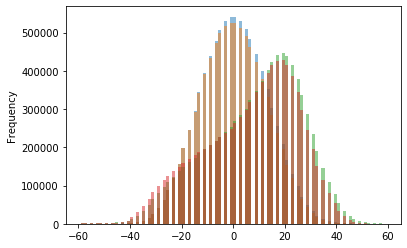

In [6]:
mask1 = df_tracker["Station"] == 'station12'
mask2 = df_tracker["Station"] == 'station18'
(df_tracker[mask2])["vertical"].plot(kind="hist",weights=(df_tracker[mask2])['counts'],bins=100,alpha=0.5)
(df_tracker[mask1])["vertical"].plot(kind="hist",weights=(df_tracker[mask1])['counts'],bins=100,alpha=0.5)
(df_tracker[mask2])["radial"].plot(kind="hist",weights=(df_tracker[mask2])['counts'],bins=100,alpha=0.5)
(df_tracker[mask1])["radial"].plot(kind="hist",weights=(df_tracker[mask1])['counts'],bins=100,alpha=0.5)

In [13]:
import matplotlib.pyplot as plt
x = (df_tracker[mask2])["radial"]
y = (df_tracker[mask2])["vertical"]
w = (df_tracker[mask2])["counts"]
x = np.asarray(x)
y = np.asarray(y)
w = np.asarray(w)
h = np.histogram2d(x, y, bins=1000, weights=w)

In [11]:
print(h[1].mean)

<built-in method mean of numpy.ndarray object at 0x11f7faf80>


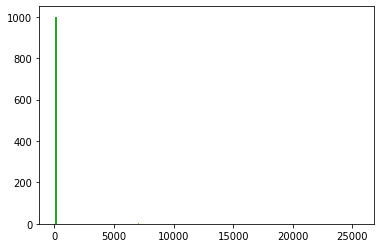

In [12]:
b = plt.hist(h[0], bins=100)

In [14]:
from scipy import stats
h = stats.histogram(x, numbins=100, weights=w)

AttributeError: module 'scipy.stats' has no attribute 'histogram'

# Preparing the data

In [160]:
#store the original sample rate for both dataframes
muons_time_interval = (df_muons.index.values[1].astype('int64')
                      - df_muons.index.values[0].astype('int64'))//1e9
field_time_interval = (df_field.index.values[1].astype('int64')
                      - df_field.index.values[0].astype('int64'))//1e9

#upsample each dataframe to 1 second                      
df_muons = df_muons.resample('1S').ffill()
df_field = df_field.resample('1S').ffill()

In [161]:
df_total = df_field.join(df_muons)
df_total = df_total.fillna(0)
factor = 1/float(muons_time_interval)
df_total['ctags_per_second'] = df_total['ctags'].astype(float)*factor

# c weighted average

In [ ]:
def ctag_field_weighting(start_time,stop_time,df,b='D'):
    """
    'b' is the field moment that you want 
    to apply the ctag weighting on
    """
   
    #first set up some variables
    eb = "e" + b #the error on the specified moment
    
    #format the input
    start_time = pd.to_datetime(start_time)
    stop_time = pd.to_datetime(stop_time)
    #select times within the specified range
    mask = ( (df.index >= start_time) & (df.index <= stop_time))
    df = df[mask]
    
    #get a series of *cumulative* ctags
    s_ctags = df['ctags'].cumsum()
    #get a series of *cumulative* products
    s_avg = (df[b]*df['ctags']).cumsum()
    #divide the *cumulative* products by the cumulative ctags, to get the cumulative ctag weighted average
    s_avg = s_avg/s_ctags
    #get the flat average (or the time average) of the field
    s_time_avg = df[b].expanding().mean()
    
    #combine the series into a df and return it
    all_series = [df['ctags'],s_ctags,s_avg,s_time_avg]
    df_new = pd.concat(all_series, axis=1)
    df_new.columns = ['new_ctags','ctags','muon_weighted_field','time_averaged_field']
    return df_new
    

In [ ]:
t1 = 'april 10 2018  6:30pm'
t2 = "april 30 2018  6:30pm and 50 seconds"
df_new = convolve_better(t1,t2,df_total)

In [ ]:
# mpld3.disable_notebook()
df_new[['muon_weighted_field','time_averaged_field']].fillna(method='ffill').plot(figsize=(12,6))
print(df_new)


In [ ]:
# mpld3.disable_notebook()
(df_new['time_averaged_field'] - df_new['muon_weighted_field']).fillna(method='ffill').plot(figsize=(12,6))

## Note that you  can make charts with plotly without slowing down the notebook by:

### 1 using fig.show(config={'staticPlot':True}), with the usual plotly.express.scatter

In [ ]:
import plotly.express as px
# Make a fig with plotly express 
fig = px.scatter(df_new.reset_index(), 
                 x="DateTime", 
                 y="muon_weighted_field")
#note that add_scatter doesn’t have the same “data frame + column names”
# API as Plotly Express, so it's called differently. 
# Note that add_scatter does allow for mixing of dfs, however...
# Also note, in the plot below, that add_scatter introduces some inconvient plot formatting defaults
fig.add_scatter(x=df_new.index, y=df_new['time_averaged_field'])

#The config={'staticPlot':True} option helps keep things running faster
fig.show(config={'staticPlot':True})

### or 2, using plotly.graph_objects.Scattergl (instead of Scatter), which plots online using WebGL

In [ ]:
import plotly.graph_objects as go
data = (df_new['time_averaged_field'] - 
        df_new['muon_weighted_field']).values
fig = go.Figure(data=go.Scattergl(y=data, mode='markers'))
fig.show()


## Note that the above results can easily be resampled with 
> resample('some value')).mean()

or


> resample('some value')).sum()

etc, depending on the type of quantity



In [ ]:
data = ((df_new['time_averaged_field'] -
         df_new['muon_weighted_field']).resample('H')).mean().values
# data
fig = go.Figure(data=go.Scattergl(y=data, mode='markers'))
fig.show()

In [ ]:
df_new.head()

In [ ]:
df_new['diff'] =  df_new['time_averaged_field'] - df_new['muon_weighted_field']
data1 = df_new['diff'].resample('20min').mean()
data1_max = (data1.max())
data2 = df_new['new_ctags'].resample('20min').sum()
data2 = data1_max*(data2)/(data2.max())
data3 = df_new['ctags'].resample('20min').sum()
data3 = data1_max*(data3)/(data3.max())

In [ ]:
#just a throw-away line to declare fig
fig = px.scatter(df_new)
#The two traces
fig.add_scatter(x=df_new.index, y=data1,mode='markers', name='field diff' )
fig.add_scatter(x=df_new.index, y=data2,mode='markers', name='ctags')
fig.add_scatter(x=df_new.index, y=data3, mode='markers', name='total ctags')
#plot non-interactivly
fig.show(config={'staticPlot':True})

In [ ]:
fig.update_layout(
    title=go.layout.Title(
        text="",
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Time",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="ppm",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)
fig.show()